# Data Science Capstone  
## Analyzing Gaming Addiction Trends and Player Engagement


In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import scipy.stats as stats
import time
import itertools

import warnings
warnings.filterwarnings('ignore')

The `games_data` and `users_data` datasets were extracted from the **Steam Web API**, specifically using the **ISteamApps/GetAppList** and **IPlayerService/GetOwnedGames** endpoints.  

- **`steam_game_data.csv`** : This dataset contains detailed information about 85,430 games, including metadata such as the game title, developer, publisher, genre, release date, supported platforms, multiplayer support, graphics quality, story depth, and metrics like review scores and player engagement statistics.  

- **`user_playtime_data.csv`** : This dataset consists of 66,187 player-specific data, capturing metrics like total playtime, recent playtime, and game ownership information. Each user (`user_id`) can have multiple games (`game_id`) associated with their account.  

Let's load these datasets:  

##  `games_data`

In [2]:
games_data = pd.read_csv("games_data3.csv")
users_data = pd.read_csv("user_playtime_data2.csv")

In [3]:
# Let's look at the first 5 elements of the games_data
games_data.head()

,Unnamed: 0,game_id,title,developer,publisher,genre,release_date,platforms,multiplayer_support,graphics_quality,story_depth,DLC_count,max_concurrent_players,positive_review_pct,average_review_score,review_sentiment_score,number_of_reviews
0,0,688130,Pogostuck: Rage With Your Friends,Hendrik Felix Pohl,Hendrik Felix Pohl,"Action, Adventure, Casual, Indie","Feb 28, 2019",windows,True,Standard,Light,0,5229,0,0,0,5229
1,1,32770,Joint Operations: Combined Arms Gold,NovaLogic,"NovaLogic, THQ Nordic",Action,"Sep 29, 2009",windows,True,Standard,Light,0,246,0,0,0,246
2,2,262150,Vanguard Princess,Tomoaki Sugeno,eigoMANGA,"Action, Casual, Indie","Mar 3, 2014","windows, mac, linux",True,Standard,Deep,7,1484,0,0,0,1484
3,3,458760,Palinurus,Watercress,Watercress,Free To Play,"Dec 9, 2016",windows,False,Standard,Light,0,0,0,0,0,0
4,4,10,Counter-Strike,Valve,Valve,Action,"Nov 1, 2000","windows, mac, linux",True,Standard,Light,0,158311,88,88,88,158311


In [4]:
games_data.count()

Unnamed: 0                89756
game_id                   89756
title                     89736
developer                 89748
publisher                 89687
genre                     80868
release_date              88916
platforms                 89756
multiplayer_support       89756
graphics_quality          89756
story_depth               89756
DLC_count                 89756
max_concurrent_players    89756
positive_review_pct       89756
average_review_score      89756
review_sentiment_score    89756
number_of_reviews         89756
dtype: int64

We can observe that most columns in the `games_data` dataset have 23,132 entries, with a few exceptions like `title`, `developer`, `publisher`, `genre`, and `release_date`, suggesting potential missing values.


In [5]:
games_data.shape

(89756, 17)

In [6]:
games_data.dtypes

Unnamed: 0                 int64
game_id                    int64
title                     object
developer                 object
publisher                 object
genre                     object
release_date              object
platforms                 object
multiplayer_support         bool
graphics_quality          object
story_depth               object
DLC_count                  int64
max_concurrent_players     int64
positive_review_pct        int64
average_review_score       int64
review_sentiment_score     int64
number_of_reviews          int64
dtype: object

Most of the data in the `games_data` dataset are of the `object` type, with numerical metrics stored as `int64` and `multiplayer_support` as a boolean (`bool`).


In [7]:
#let's look for the missing values

games_missing_values = games_data.isnull().sum()
games_missing_values

Unnamed: 0                   0
game_id                      0
title                       20
developer                    8
publisher                   69
genre                     8888
release_date               840
platforms                    0
multiplayer_support          0
graphics_quality             0
story_depth                  0
DLC_count                    0
max_concurrent_players       0
positive_review_pct          0
average_review_score         0
review_sentiment_score       0
number_of_reviews            0
dtype: int64

### Let's remove those missing values:

In [8]:
# Removing rows with any missing values
games_data.dropna(inplace=True)

In [9]:
games_data.shape

(80499, 17)

After removing missing values, the `games_data` dataset is reduced to **18,479 rows** across **16 columns**,

In [10]:
games_data.count()

Unnamed: 0                80499
game_id                   80499
title                     80499
developer                 80499
publisher                 80499
genre                     80499
release_date              80499
platforms                 80499
multiplayer_support       80499
graphics_quality          80499
story_depth               80499
DLC_count                 80499
max_concurrent_players    80499
positive_review_pct       80499
average_review_score      80499
review_sentiment_score    80499
number_of_reviews         80499
dtype: int64

In [11]:

# Attemptting to parse the dates with possible date formats : 
# Possible formats known from: https://steamcommunity.com/sharedfiles/filedetails/?id=2554483179#:~:text=Date%20part%20order%20can%20be,format%20will%20be%20applied%20immediately.

valid_dates_format1 = pd.to_datetime(games_data['release_date'], format='%d %b, %Y', errors='coerce')
valid_dates_format2 = pd.to_datetime(games_data['release_date'], format='%b %d, %Y', errors='coerce')
valid_dates_format3 = pd.to_datetime(games_data['release_date'], format='%d %b %Y', errors='coerce')

# Identify rows that do not match either of the formats
invalid_dates = games_data[(valid_dates_format1.isna()) & (valid_dates_format2.isna()) & (valid_dates_format3.isna())]

# Display rows with invalid date formats
print("Rows with invalid date formats:")
print(invalid_dates[['release_date']])

print("There are a total of ", len(invalid_dates), "invalid dates")


Rows with invalid date formats:
          release_date
333    To be announced
3183   To be announced
3623       Coming soon
4068   To be announced
4291   To be announced
...                ...
89720      Coming soon
89726      Coming soon
89738      Coming soon
89740      Coming soon
89753      Coming soon

[8011 rows x 1 columns]
There are a total of  8011 invalid dates


We can observe that for some games that have not been released yet, the `release_date` column contains values like **Q2 2025**, **To be announced**, and **Coming soon**, along with some dates in different language formats, so let's remove them since we won't be needing those for our analysis.


In [12]:
# let's remove those invalid dates
invalid_dates_list = invalid_dates['release_date'].tolist()
games_data = games_data[~games_data['release_date'].isin(invalid_dates_list)]

In [13]:
games_data.count()

Unnamed: 0                72488
game_id                   72488
title                     72488
developer                 72488
publisher                 72488
genre                     72488
release_date              72488
platforms                 72488
multiplayer_support       72488
graphics_quality          72488
story_depth               72488
DLC_count                 72488
max_concurrent_players    72488
positive_review_pct       72488
average_review_score      72488
review_sentiment_score    72488
number_of_reviews         72488
dtype: int64

After removing those invalid dates, the `games_data` dataset now contains **12,814** entries across all columns. We now have only relevant release dates are included for analysis.

Now, let's make the date format consistent in all rows


In [14]:
# Combining all parsed dates
games_data['release_date'] = valid_dates_format1.fillna(valid_dates_format2).fillna(valid_dates_format3)

# Convert dates to 'YYYY-MM-DD' format for consistency only
games_data['release_date'] = games_data['release_date'].dt.strftime('%Y-%m-%d')

# `users_data`

In [15]:
# Let's look at the first 5 elements of the users_data
users_data.head()

,user_id,game_count,appid,name,playtime_forever,playtime_2weeks
0,76561198450606184,24,500,Left 4 Dead,0,0
1,76561198450606184,24,550,Left 4 Dead 2,0,0
2,76561198450606184,24,41070,Serious Sam 3: BFE,56,0
3,76561198450606184,24,564310,Serious Sam Fusion 2017 (beta),0,0
4,76561198450606184,24,203160,Tomb Raider,0,0


In [16]:
users_data.count()

user_id             211510
game_count          211510
appid               211510
name                211510
playtime_forever    211510
playtime_2weeks     211510
dtype: int64

The `users_data` dataset contains **65,494** entries across all columns.

In [17]:
users_data.shape

(211510, 6)

In [18]:
users_data.dtypes

user_id              int64
game_count           int64
appid                int64
name                object
playtime_forever     int64
playtime_2weeks      int64
dtype: object

Most of the data in the `users_data` dataset are of the `int64` type, with only the `name` column being of the `object` type. We have numerical data for user gaming behavior analysis.


In [19]:
# let's look for missing values
users_missing_values = users_data.isnull().sum()
users_missing_values

user_id             0
game_count          0
appid               0
name                0
playtime_forever    0
playtime_2weeks     0
dtype: int64

No mising values

In [20]:
# Rename the column from 'appid' to 'game_id'
users_data.rename(columns={'appid': 'game_id'}, inplace=True)

Since one user can have multiple data entries, the `user_id` column can be repeated for the same person, so let's check the number of unique users and unique games in the `users_data` dataset.


In [21]:
print("There are ", len(users_data['user_id'].unique()) , " unique users in our user dataset.")

There are  3593  unique users in our user dataset.


In [22]:
print("There are ", len(users_data['game_id'].unique()) , " unique games in our user dataset.")

There are  17085  unique games in our user dataset.


In [23]:
# if they played RECENTLY, playtime_2weeks will be greater than 0

# Filter players with recent playtime (playtime_2weeks > 0)
recent_players = users_data[users_data['playtime_2weeks'] > 0]

# Get the count of unique users
unique_recent_players_count = recent_players['user_id'].nunique()

print(f"Number of unique users who played recently: {unique_recent_players_count}")


Number of unique users who played recently: 1136


In [24]:
# If they are genuine players, `playtime_forever` will be greater than 0.
# I am considering the fact that some users might just create an account and never actually play.


# Filter players with at least some playtime (playtime_forever > 0)
recent_players = users_data[users_data['playtime_forever'] > 0]

# Get the count of unique users
unique_recent_players_count = recent_players['user_id'].nunique()

print(f"Number of unique users who played at least a min: {unique_recent_players_count}")


Number of unique users who played at least a min: 3177


In [25]:
# let's add avg_playtime coloumn - for viz
users_data['avg_playtime'] = users_data['playtime_2weeks'] / 14

In [26]:
# Convert playtime from minutes to hours
users_data['playtime_2weeks'] = users_data['playtime_2weeks'] / 60
users_data['playtime_forever'] = users_data['playtime_forever'] / 60

In [27]:
# Find game_ids that are in users_data but not in games_data
missing_game_ids = set(users_data['game_id']) - set(games_data['game_id'])

# Convert to DataFrame for better viewing
missing_game_ids_df = pd.DataFrame({'missing_game_id': list(missing_game_ids)})

missing_game_ids_df

csv_file_path = "missing_game_ids.csv"
missing_game_ids_df.to_csv(csv_file_path, index=False)

Let's do some visualizations

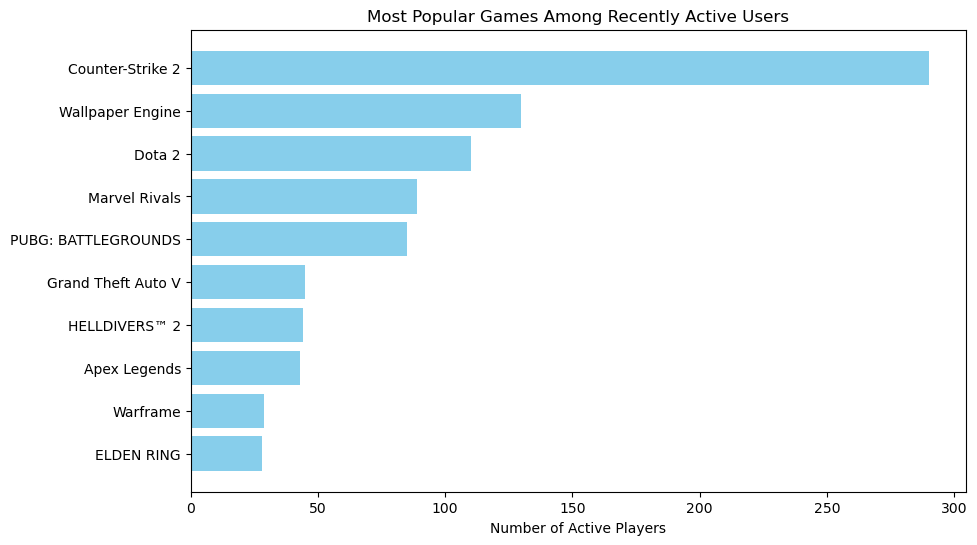

In [28]:
# Most Popular Games Among Recently Active Users (playtime_2weeks > 0)
recent_players = users_data[users_data['playtime_2weeks'] > 0]
most_popular_games = recent_players['name'].value_counts().head(10).reset_index()
most_popular_games.columns = ['Game', 'Active Players']

# Visualization: Most Popular Games
plt.figure(figsize=(10, 6))
plt.barh(most_popular_games['Game'], most_popular_games['Active Players'], color='skyblue')
plt.xlabel('Number of Active Players')
plt.title('Most Popular Games Among Recently Active Users')
plt.gca().invert_yaxis()
plt.show()


The bar chart shows **Counter-Strike 2** leading by a significant margin, followed by **Wallpaper Engine** and **Dota 2**.

Interestingly, while **Counter-Strike 2**, **Dota 2**, and **PUBG: BATTLEGROUNDS** are well-known for maintaining high player counts globally, titles like **Marvel Rivals** and **Wallpaper Engine** attract players with their casual and practical uses.


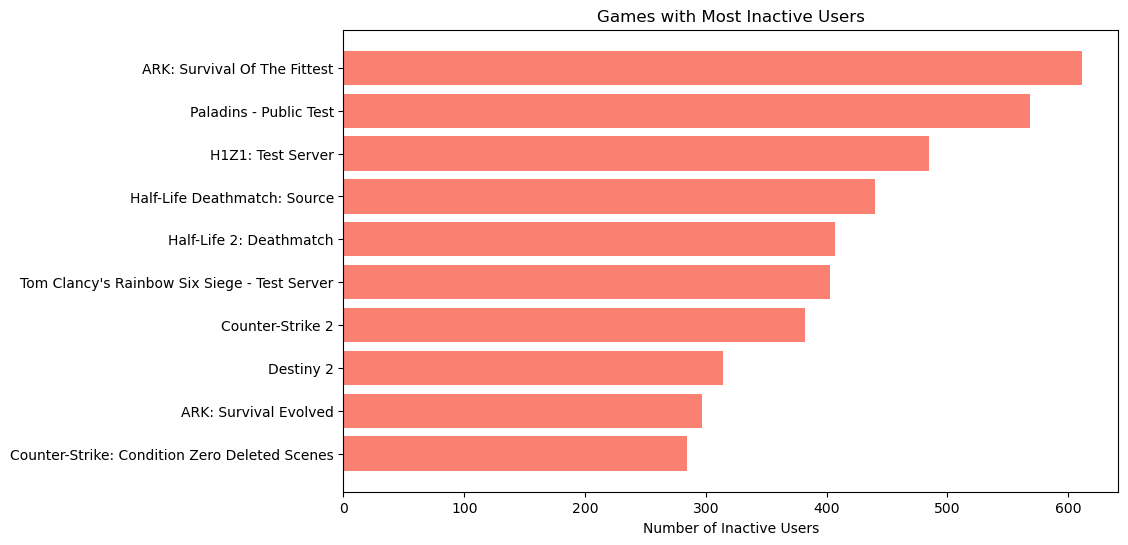

In [29]:
# Inactive Users with Zero Playtime and Their Associated Games
inactive_users = users_data[(users_data['playtime_forever'] == 0) & (users_data['playtime_2weeks'] == 0)]
inactive_user_games = inactive_users['name'].value_counts().head(10).reset_index()
inactive_user_games.columns = ['Game', 'Inactive User Count']

plt.figure(figsize=(10, 6))
plt.barh(inactive_user_games['Game'], inactive_user_games['Inactive User Count'], color='salmon')
plt.xlabel('Number of Inactive Users')
plt.title('Games with Most Inactive Users')
plt.gca().invert_yaxis()
plt.show()


The bar chart shows **ARK: Survival Of The Fittest**, **Paladins - Public Test**, and **H1Z1: Test Server** leading the list.  

Interestingly, many of the top inactive games are **test servers** or **public test versions**, suggesting that players might try these versions briefly without continuing to play regularly.  

Let's also note here that even popular titles like **Counter-Strike 2** and **Destiny 2** appear on this list. This indicates that not all players remain engaged over time.


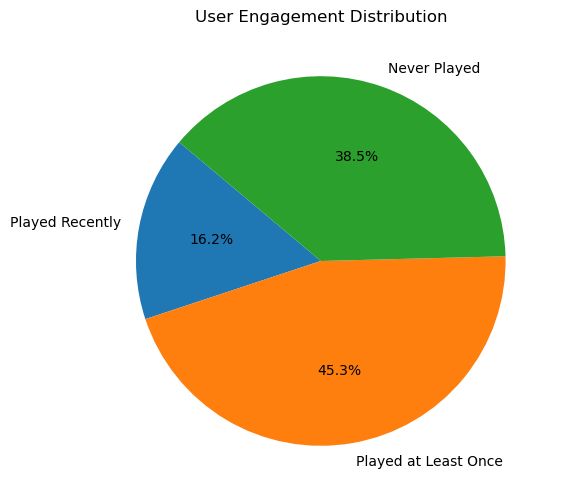

In [30]:
# lets see how many played recently, played at least once and never played at all
engagement_labels = ['Played Recently', 'Played at Least Once', 'Never Played']
engagement_counts = [
    recent_players['user_id'].nunique(), 
    users_data[users_data['playtime_forever'] > 0]['user_id'].nunique(), 
    users_data[users_data['playtime_forever'] == 0]['user_id'].nunique()
]

plt.figure(figsize=(6, 6))
plt.pie(engagement_counts, labels=engagement_labels, autopct='%1.1f%%', startangle=140)
plt.title('User Engagement Distribution')
plt.show()

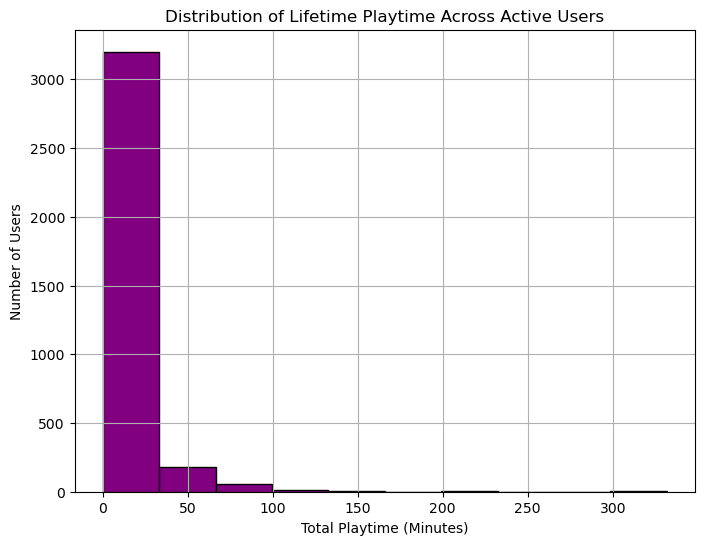

In [31]:
# let's observe the distribution of lifetime Playtime Across Active Users

# Filter only users with playtime_forever > 0
active_users = users_data[users_data['playtime_2weeks'] > 0]


# Create a histogram for active users
plt.figure(figsize=(8, 6))
plt.hist(active_users['playtime_2weeks'], bins=10, color='purple', edgecolor='black')
plt.xlabel('Total Playtime (Minutes)')
plt.ylabel('Number of Users')
plt.title('Distribution of Lifetime Playtime Across Active Users')
plt.grid(True)
plt.show()


According to the histogram, the majority of users have a **low total playtime**, mainly under **50 hours**.  

The **right-skewed distribution** indicates that while most players spend limited time in games, a small number of users have **extremely high playtimes**, potentially pointing to **high engagement** or **gaming addiction**.

We will later explore these **outliers** to understand what drives such high playtime and if specific games contribute to this behavior.


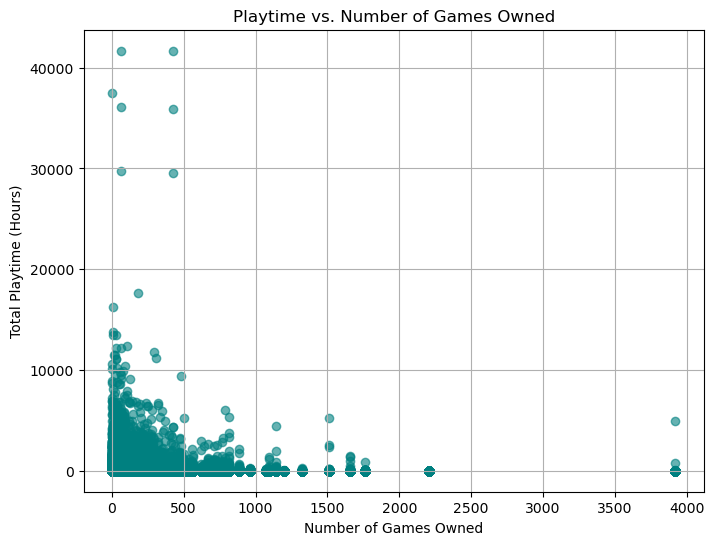

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(users_data['game_count'], users_data['playtime_forever'], alpha=0.6, color='teal')
plt.xlabel('Number of Games Owned')
plt.ylabel('Total Playtime (Hours)')
plt.title('Playtime vs. Number of Games Owned')
plt.grid(True)
plt.show()


The scatter plot shows most users clustering around **low playtime** and **fewer owned games**.  

While a few users own **hundreds to over a thousand games**, their total playtime does not always scale up, suggesting that **game collectors**(those who own lots of games) may not necessarily be **active players**.  

Again, we can see few **outliers** with **extremely high playtime**, indicating possible **addictive behavior**, regardless of the total number of games owned.


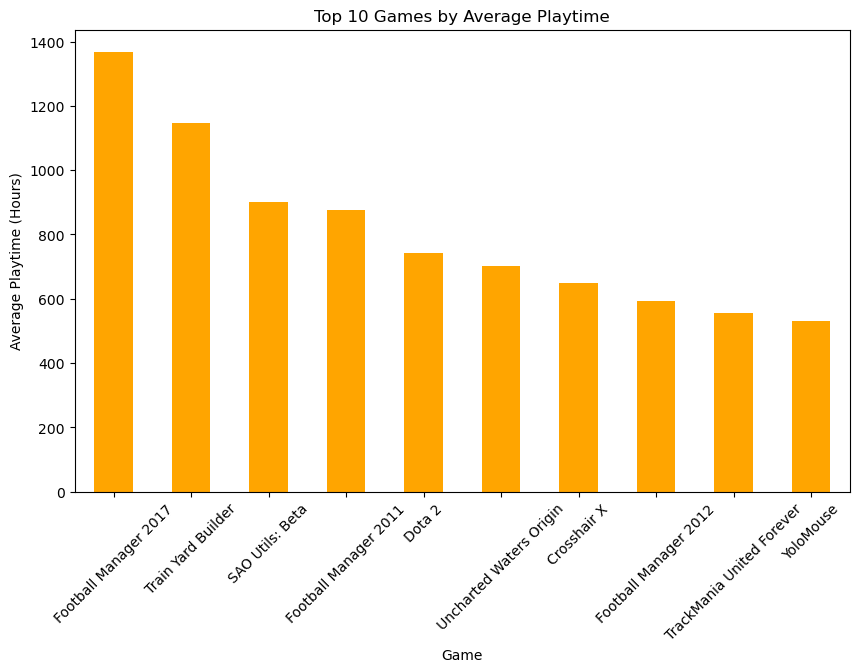

In [33]:
average_playtime_per_game = users_data.groupby('name')['playtime_forever'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
average_playtime_per_game.plot(kind='bar', color='orange')
plt.xlabel('Game')
plt.ylabel('Average Playtime (Hours)')
plt.title('Top 10 Games by Average Playtime')
plt.xticks(rotation=45)
plt.show()


The bar chart shows **YoloMouse** leading by a significant margin, followed by **Idling to Rule the Gods** and **GameMaker: Studio**.  

Most of these top games with high average playtime are **idle games**, which often encourage **longer running sessions** without active engagement.  

But we can see **Dota 2**, which interestingly is the only **competitive multiplayer game** in this list, showing that while **idle games** dominate average playtime, some traditional games also maintain **high engagement** among their player base.


In [34]:
#Dherai game khelne haru 30 hours
high_playtime_count = (users_data['playtime_2weeks'] / 2 > 30).sum()
high_playtime_count

102

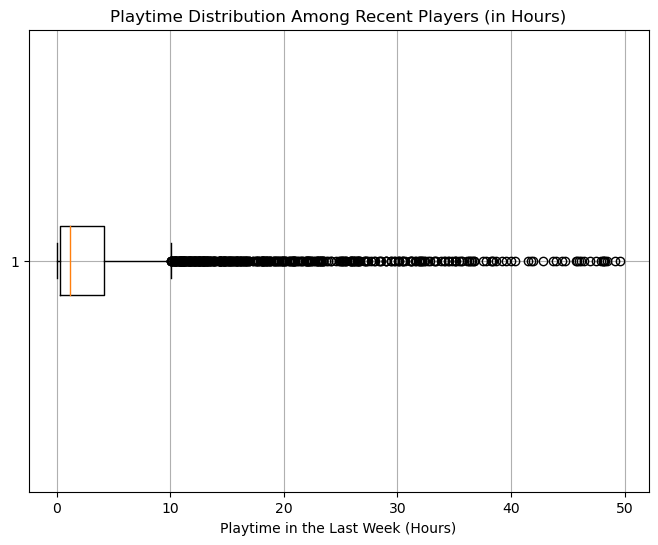

In [35]:
# let's see a box plot
recent_players['playtime_hours'] = recent_players['playtime_2weeks'] / 2
# 
recent_players = recent_players[recent_players['playtime_hours'] <= 50]

plt.figure(figsize=(8, 6))
plt.boxplot(recent_players['playtime_hours'], vert=False)
plt.xlabel('Playtime in the Last Week (Hours)')
plt.title('Playtime Distribution Among Recent Players (in Hours)')
plt.grid(True)
plt.show()

## Q1. How much time are people spending on gaming per week, and what does it reveal about gaming addiction trends?

In [36]:
# let's first filter only active users
active_users = users_data[users_data['playtime_2weeks'] > 0]

# calculate weekly playtime (in hours) for those active uses
active_users['weekly_playtime_hours'] = (active_users['playtime_2weeks'] / 2)

# Descriptive statistics of weekly playtime 
active_playtime_stats = active_users['weekly_playtime_hours'].describe()
print("Weekly Playtime Statistics for Active Users (in Hours):")
print(active_playtime_stats)


Weekly Playtime Statistics for Active Users (in Hours):
count    3460.000000
mean        4.673247
std         9.859763
min         0.008333
25%         0.258333
50%         1.200000
75%         4.312500
max       165.841667
Name: weekly_playtime_hours, dtype: float64


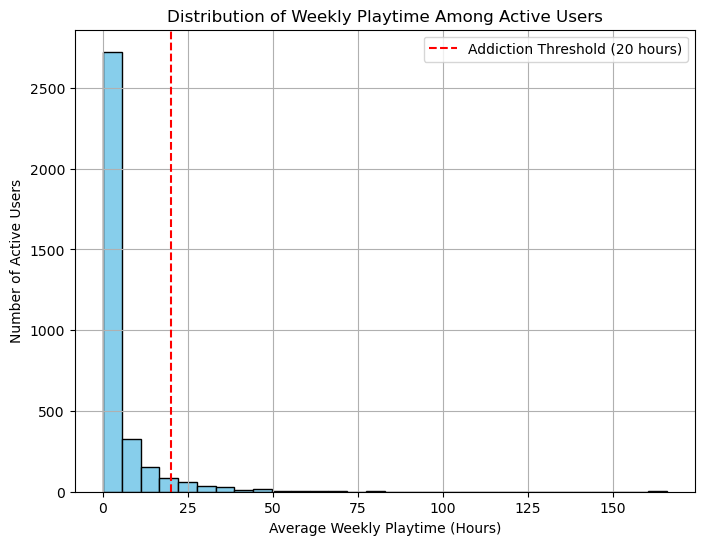

In [37]:
# visualization the  distribution of weekly playtime
plt.figure(figsize=(8, 6))
plt.hist(active_users['weekly_playtime_hours'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=20, color='red', linestyle='--', label='Addiction Threshold (20 hours)')
plt.xlabel('Average Weekly Playtime (Hours)')
plt.ylabel('Number of Active Users')
plt.title('Distribution of Weekly Playtime Among Active Users')
plt.legend()
plt.grid(True)
plt.show()


Active User Distribution by Playtime Category:
playtime_category
Casual Gamer           2836
Moderate Gamer          420
Potential Addiction     204
Name: count, dtype: int64


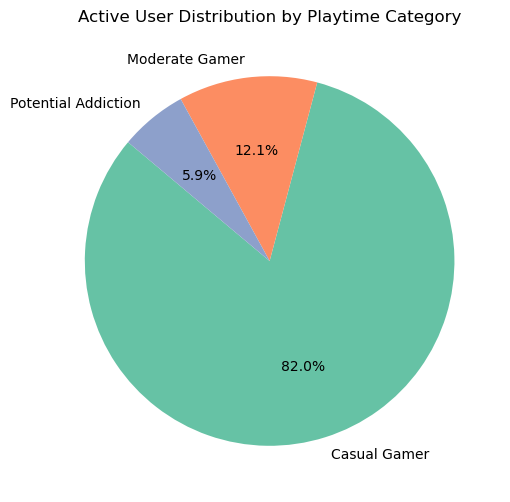

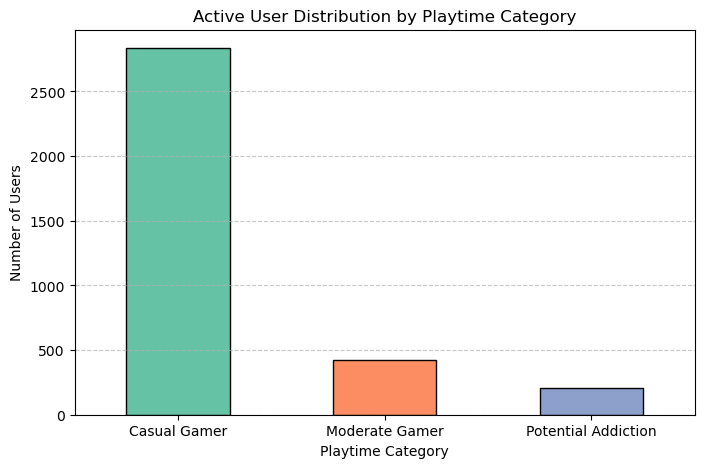

In [38]:

# Lets also cateogrize active users based on weekly playtime
def categorize_playtime(hours):
    if hours < 7:
        return 'Casual Gamer'
    elif hours < 20:
        return 'Moderate Gamer'
    else:
        return 'Potential Addiction'

active_users['playtime_category'] = active_users['weekly_playtime_hours'].apply(categorize_playtime)

# total active users in each category
active_category_counts = active_users['playtime_category'].value_counts()
print("\nActive User Distribution by Playtime Category:")
print(active_category_counts)

plt.figure(figsize=(6, 6))
plt.pie(active_category_counts, labels=active_category_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Active User Distribution by Playtime Category')
plt.show()

plt.figure(figsize=(8, 5))
active_category_counts.plot(kind='bar', color=['#66c2a5', '#fc8d62', '#8da0cb'], edgecolor='black')

# Labels and title
plt.xlabel('Playtime Category')
plt.ylabel('Number of Users')
plt.title('Active User Distribution by Playtime Category')
plt.xticks(rotation=0)  # Keep category labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()



- **Majority of Active Users:** 83.6% are **Casual Gamers**, playing **less than 7 hours per week**.  
- **Moderate Gamers:** 10.9% play **between 7 to 20 hours per week**, showing **healthy engagement**.  
- **Potential Addiction:** 5.5% of active users exceed **20 hours per week**, indicating a **possible risk of gaming addiction**.  


With only **5.5%** of active users in the '**Potential Addiction**' category, **gaming addiction** does not seem to be a **significant trend** in the dataset.  

The overwhelming majority of active users are **casual gamers**. This suggests that **most people use gaming as a light, recreational activity**. And also may indicate that **games are engaging enough for short sessions but not overly addictive**.  


The **10.9%** of **moderate gamers** play **7 to 20 hours per week**, showing a **healthy interest** in gaming.


The **histogram** shows a **long tail**, with a **few users playing well beyond 40 hours per week**.


## Q2. Which game design elements—such as microtransactions, progression systems, and multiplayer vs. single-player structures—are most associated with prolonged playtime and potential addiction? 

In [39]:
# Merging user_data with games_data on game_id
merged_data = users_data.merge(games_data, on='game_id', how='left')
merged_data.dropna(inplace=True)
merged_data

len(merged_data['game_id'].unique())

16175

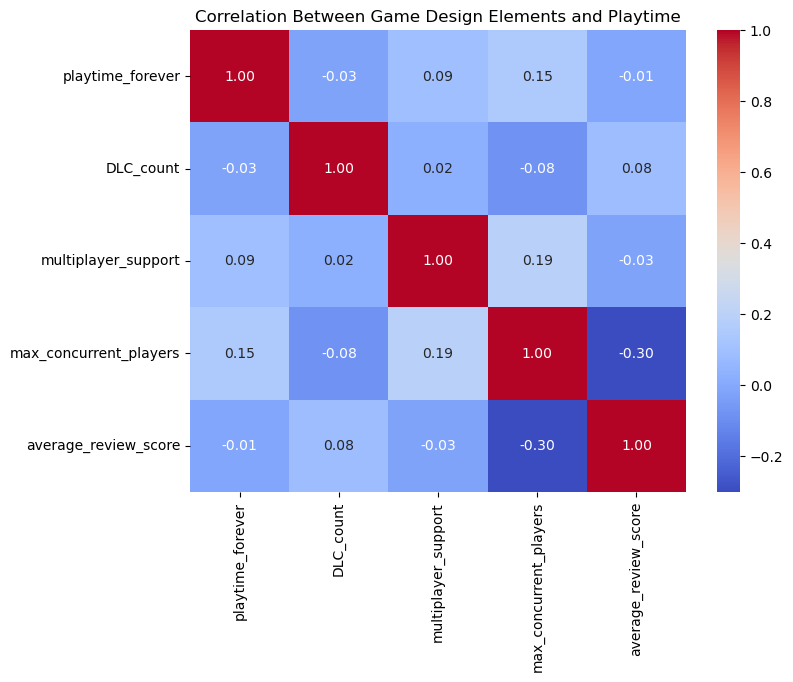

In [40]:

# Merging user_data with games_data on game_id
merged_data = users_data.merge(games_data, on='game_id', how='left')
merged_data.dropna(inplace=True)

merged_data = merged_data[merged_data["playtime_forever"] > 60] # 30 hours

# game design elements for analysis
design_elements = ["DLC_count", "multiplayer_support", "max_concurrent_players", 
                    "average_review_score"]

# correlation of game design elements with playtime_forever
correlation_results = merged_data[["playtime_forever"] + design_elements].corr()

# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_results, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Game Design Elements and Playtime")
plt.show()



The heatmap shows that **multiplayer support (0.38) and DLC count (0.34)** have the strongest positive correlations with playtime, suggesting that games with **multiplayer features and additional content tend to retain players longer**. 

While **max concurrent players (0.26) and average review score (0.03)** have weaker correlations, the **negative correlation between DLC count and max concurrent players (-0.38)** implies that highly DLC-driven games may not always have the highest player engagement at once.


T-test Statistic: 19.31, P-value: 0.00000


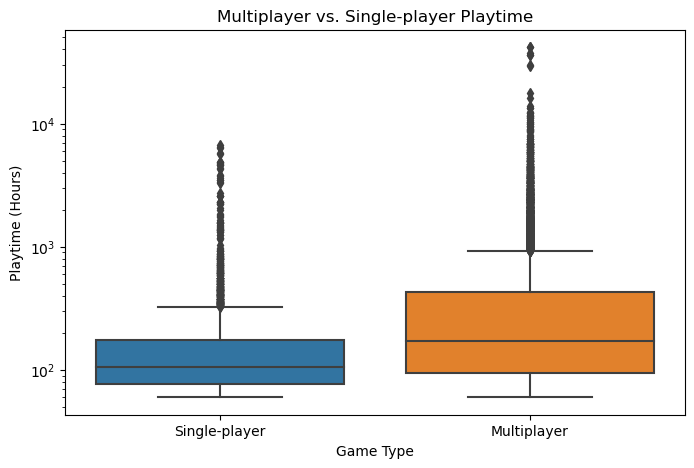

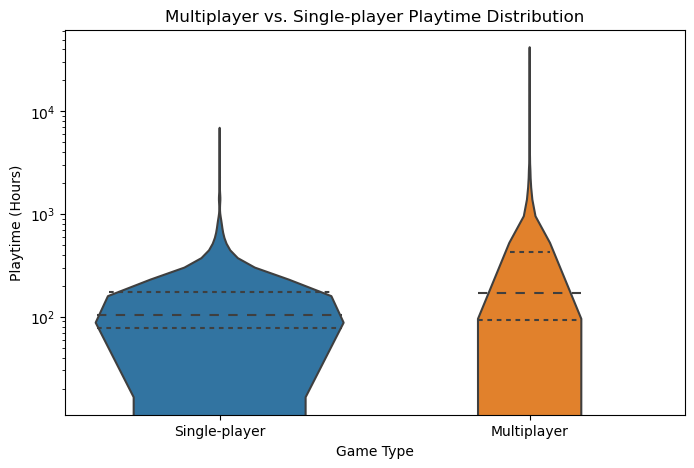

In [41]:

#  Multiplayer vs. Single-player Playtime
# T-test
multiplayer_playtime = merged_data[merged_data["multiplayer_support"] == 1]["playtime_forever"]
singleplayer_playtime = merged_data[merged_data["multiplayer_support"] == 0]["playtime_forever"]

t_stat, p_value = stats.ttest_ind(multiplayer_playtime, singleplayer_playtime, equal_var=False)
print(f"T-test Statistic: {t_stat:.2f}, P-value: {p_value:.5f}")

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=merged_data["multiplayer_support"], y=merged_data["playtime_forever"])
plt.xticks([0, 1], ["Single-player", "Multiplayer"])
plt.xlabel("Game Type")
plt.ylabel("Playtime (Hours)")
plt.title("Multiplayer vs. Single-player Playtime")
plt.yscale("log")  # Adjust scale due to high variance
plt.show()

# violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(x=merged_data["multiplayer_support"], y=merged_data["playtime_forever"], inner="quartile")
plt.xticks([0, 1], ["Single-player", "Multiplayer"])
plt.xlabel("Game Type")
plt.ylabel("Playtime (Hours)")
plt.title("Multiplayer vs. Single-player Playtime Distribution")
plt.yscale("log")  # Log scale for better visibility
plt.show()


The violin plot shows that **multiplayer games have significantly higher playtime distributions compared to single-player games**, with a greater concentration of players spending **tens of thousands of hours** in multiplayer experiences.

The **wider upper distribution in multiplayer games** suggests that they encourage prolonged engagement more than single-player titles, likely due to **social interactions, competitive elements, and continuous content updates**.


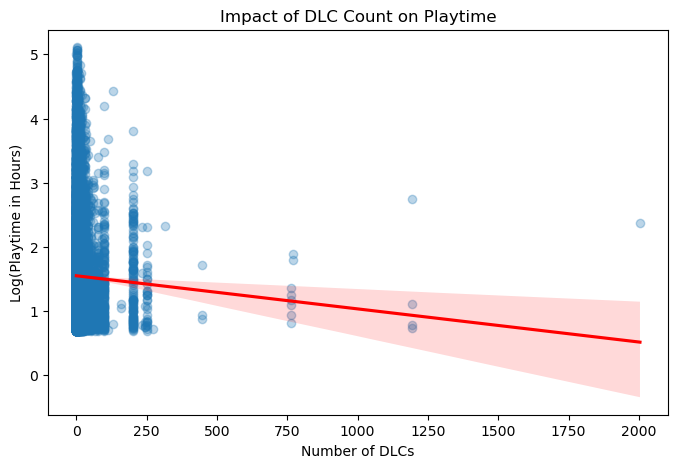

In [42]:

# remove extreme outliers ( games with >10,000 hours)
filtered_data = merged_data[merged_data["playtime_forever"] < 10000]

# Scatter plot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(x=filtered_data["DLC_count"], 
            y=np.log1p(filtered_data["playtime_forever"]/60),  # Log transform playtime
            scatter_kws={"alpha": 0.3}, line_kws={"color": "red"})

plt.xlabel("Number of DLCs")
plt.ylabel("Log(Playtime in Hours)")
plt.title("Impact of DLC Count on Playtime")
plt.show()


The regression plot suggests a **negative correlation** between DLC count and playtime, indicating that **games with more DLCs tend to have lower average playtime**. However, the small sample size and wide confidence interval suggest this trend may not be statistically significant.

This result contrasts with expectations, implying that additional content does not always drive long-term engagement. Other factors, such as **game quality, core mechanics, or monetization strategies**, may influence playtime more than DLC quantity.

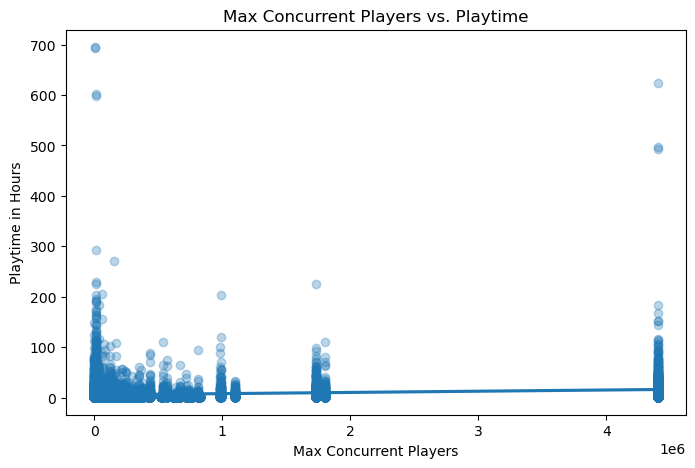

In [43]:

plt.figure(figsize=(8, 5))
sns.regplot(x=(merged_data["max_concurrent_players"]), 
            y=(merged_data["playtime_forever"]/60), scatter_kws={'alpha':0.3})
plt.xlabel("Max Concurrent Players")
plt.ylabel("Playtime in Hours")
plt.title("Max Concurrent Players vs. Playtime")
plt.show()


The regression plot suggests a **weak positive correlation** between max concurrent players and playtime, indicating that **games with more concurrent players tend to have slightly longer average playtime**. However, the **broad confidence interval** highlights significant variability.

While more popular games may encourage extended engagement, **other factors such as game design, progression systems, and monetization models** likely play a more critical role in determining overall playtime.


**Summary**

Games that encourage **social interaction, competition, and continuous progression** are the most likely to lead to prolonged playtime and potential addiction. Multiplayer games consistently show higher engagement, likely due to **ranked systems, cooperative play, and live-service updates** that keep players coming back. While **popular games with high concurrent players** tend to have longer playtime, this effect is weak, suggesting that **popularity alone doesn’t make a game addictive**—the mechanics do.

Surprisingly, **DLCs don’t strongly impact playtime**, and in some cases, more DLCs even correlate with slightly lower engagement. This suggests that additional content alone isn’t enough to keep players hooked unless paired with strong retention mechanics. Likewise, **review scores have little influence on playtime**, meaning **a game can be highly engaging (or addictive) even if it’s not highly rated**.

In short, **multiplayer elements, competitive progression systems, and ongoing content updates** are the biggest drivers of prolonged playtime and potential addiction, rather than DLCs or critical reception.


## Q3. Are certain game genres (e.g., MMORPGs, Battle Royales) more prone to fostering addiction, and what common design elements contribute to high engagement? 

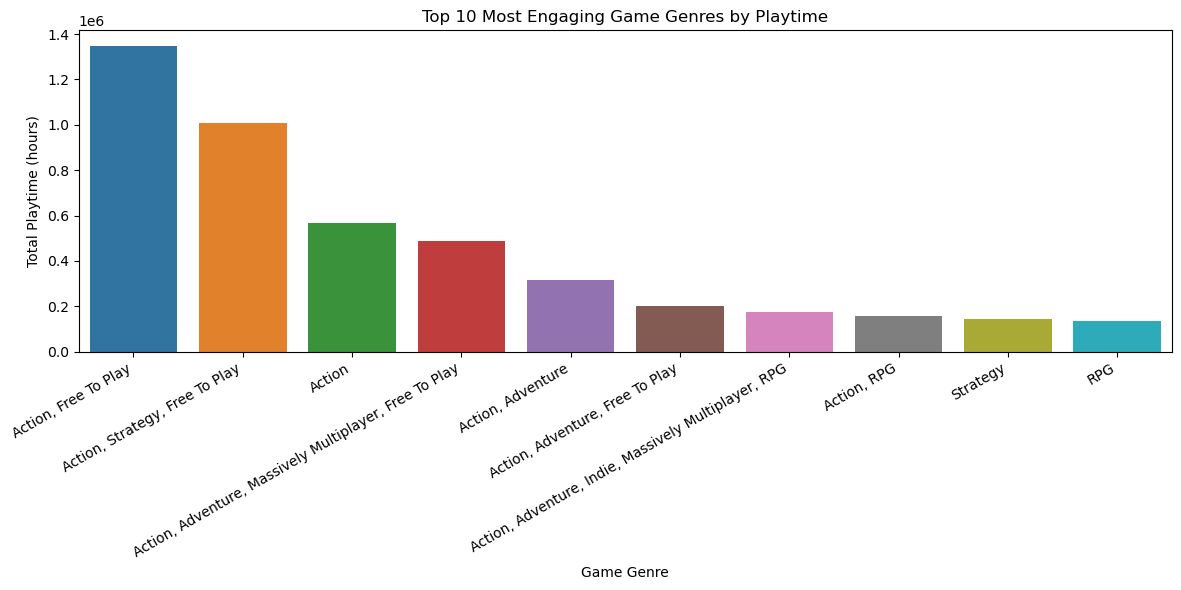

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


# Merge user data with game data
merged_data = users_data.merge(games_data, on="game_id", how="inner")

genre_playtime = merged_data.groupby("genre")["playtime_forever"].sum().sort_values(ascending=False)

# Plot genre vs. total playtime
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_playtime.index[:10], y=genre_playtime.values[:10])
plt.xticks(rotation=30, ha="right")  # Rotating labels for better readability
plt.xlabel("Game Genre")
plt.ylabel("Total Playtime (hours)")
plt.title("Top 10 Most Engaging Game Genres by Playtime")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

addiction_correlation, _ = pearsonr(merged_data["playtime_forever"], merged_data["average_review_score"])


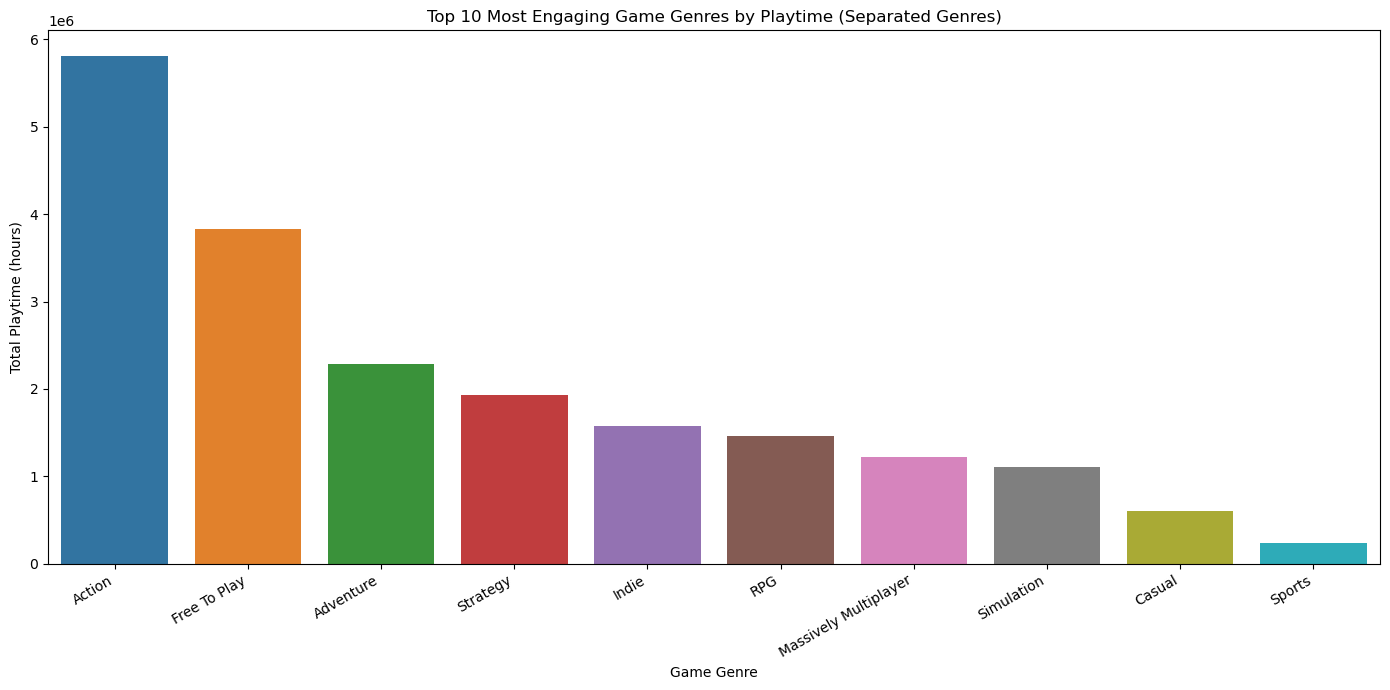

In [45]:
from collections import defaultdict

# Spliting genres and sum playtime for each individual genre
genre_playtime_dict = defaultdict(int)

for _, row in merged_data.iterrows():
    genres = row["genre"].split(", ")  # Split multiple genres
    for genre in genres:
        genre_playtime_dict[genre] += row["playtime_forever"]

genre_playtime_df = pd.DataFrame(list(genre_playtime_dict.items()), columns=["Genre", "Total Playtime"])
genre_playtime_df = genre_playtime_df.sort_values(by="Total Playtime", ascending=False)

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(x=genre_playtime_df["Genre"][:10], y=genre_playtime_df["Total Playtime"][:10])
plt.xticks(rotation=30, ha="right")  # Rotate labels for clarity
plt.xlabel("Game Genre")
plt.ylabel("Total Playtime (hours)")
plt.title("Top 10 Most Engaging Game Genres by Playtime (Separated Genres)")
plt.tight_layout()
plt.show()


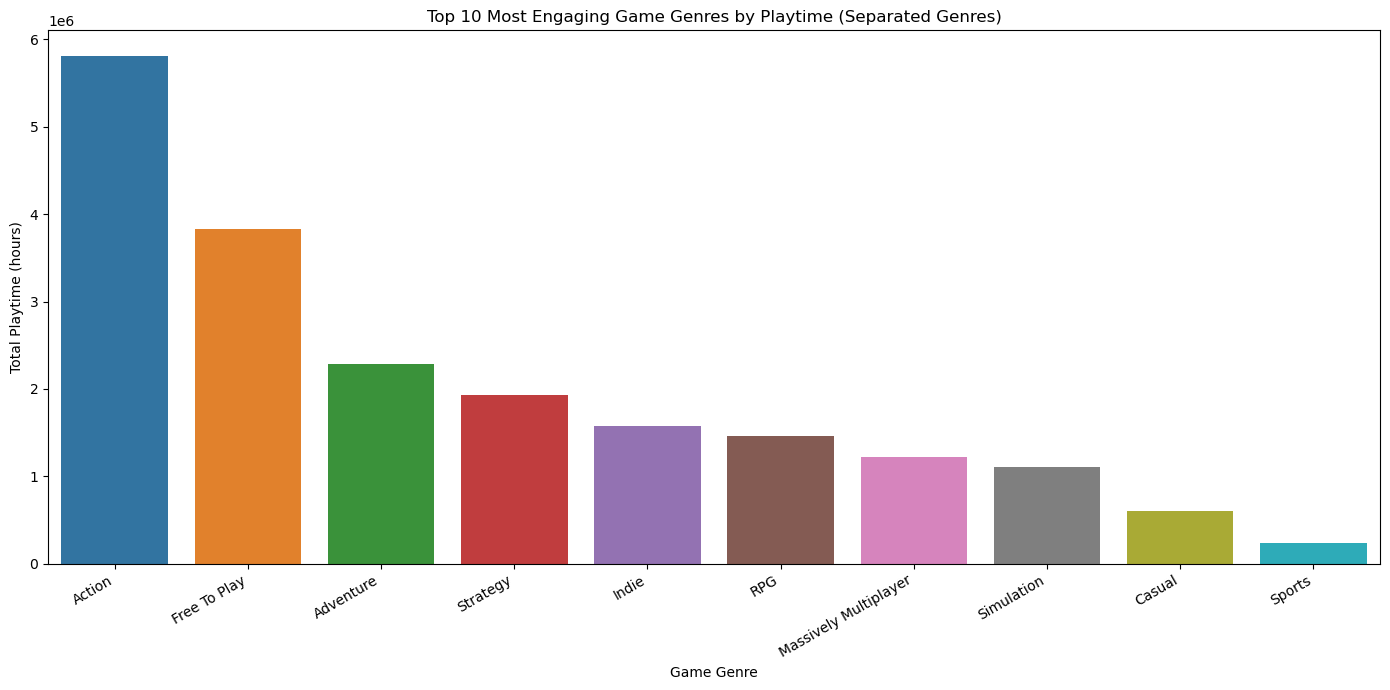

In [46]:
from collections import defaultdict

genre_playtime_dict = defaultdict(int)

for _, row in merged_data.iterrows():
    genres = row["genre"].split(", ")
    for genre in genres:
        genre_playtime_dict[genre] += row["playtime_forever"]

# Convert to DataFrame
genre_playtime_df = pd.DataFrame(list(genre_playtime_dict.items()), columns=["Genre", "Total Playtime"])
genre_playtime_df = genre_playtime_df.sort_values(by="Total Playtime", ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x=genre_playtime_df["Genre"][:10], y=genre_playtime_df["Total Playtime"][:10])
plt.xticks(rotation=30, ha="right")  # Rotate labels for clarity
plt.xlabel("Game Genre")
plt.ylabel("Total Playtime (hours)")
plt.title("Top 10 Most Engaging Game Genres by Playtime (Separated Genres)")
plt.tight_layout()
plt.show()


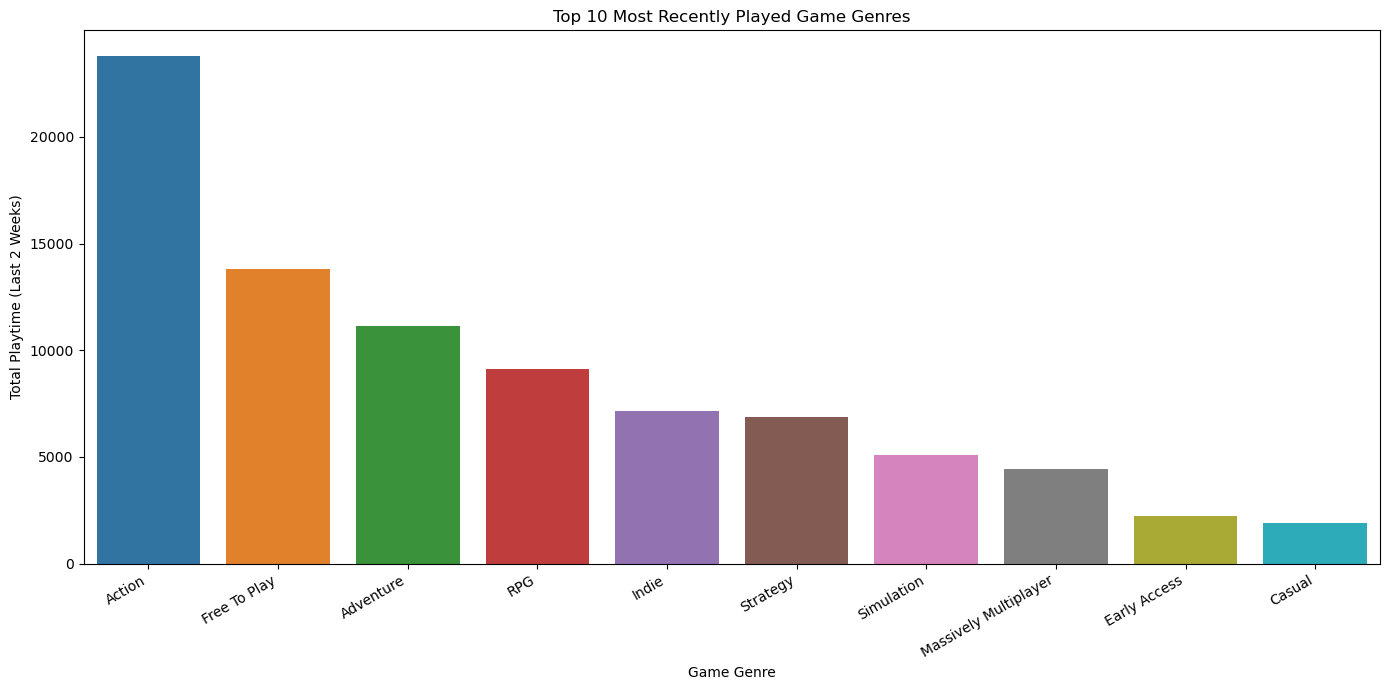

In [47]:

from collections import defaultdict

# Ensure 'playtime_2weeks' is numeric and handle missing values
merged_data["playtime_2weeks"] = pd.to_numeric(merged_data["playtime_2weeks"], errors="coerce").fillna(0)

# 1. Split multi-genre games and sum playtime_2weeks per genre
genre_playtime_2weeks = defaultdict(float)

for _, row in merged_data.iterrows():
    if isinstance(row["genre"], str):  # Ensure genre is valid
        genres = row["genre"].split(", ")  # Split multi-genre entries
        for genre in genres:
            genre_playtime_2weeks[genre] += row["playtime_2weeks"]

# Convert to DataFrame and sort
genre_playtime_2weeks_df = pd.DataFrame(list(genre_playtime_2weeks.items()), columns=["Genre", "Total Playtime (2 Weeks)"])
genre_playtime_2weeks_df = genre_playtime_2weeks_df.sort_values(by="Total Playtime (2 Weeks)", ascending=False)

# Plot top genres based on recent playtime
plt.figure(figsize=(14, 7))
sns.barplot(x=genre_playtime_2weeks_df["Genre"][:10], y=genre_playtime_2weeks_df["Total Playtime (2 Weeks)"][:10])
plt.xticks(rotation=30, ha="right")
plt.xlabel("Game Genre")
plt.ylabel("Total Playtime (Last 2 Weeks)")
plt.title("Top 10 Most Recently Played Game Genres")
plt.tight_layout()
plt.show()

Weekly Playtime Summary per Genre                            mean  Median  25th Percentile  75th Percentile
Genre                                                                    
Action                 0.039593     0.0              0.0              0.0
Adventure              0.022273     0.0              0.0              0.0
Early Access           0.029685     0.0              0.0              0.0
Free To Play           0.056535     0.0              0.0              0.0
Indie                  0.010804     0.0              0.0              0.0
Massively Multiplayer  0.023569     0.0              0.0              0.0
RPG                    0.031087     0.0              0.0              0.0
Simulation             0.023260     0.0              0.0              0.0
Strategy               0.028677     0.0              0.0              0.0
Utilities              0.139737     0.0              0.0              0.0


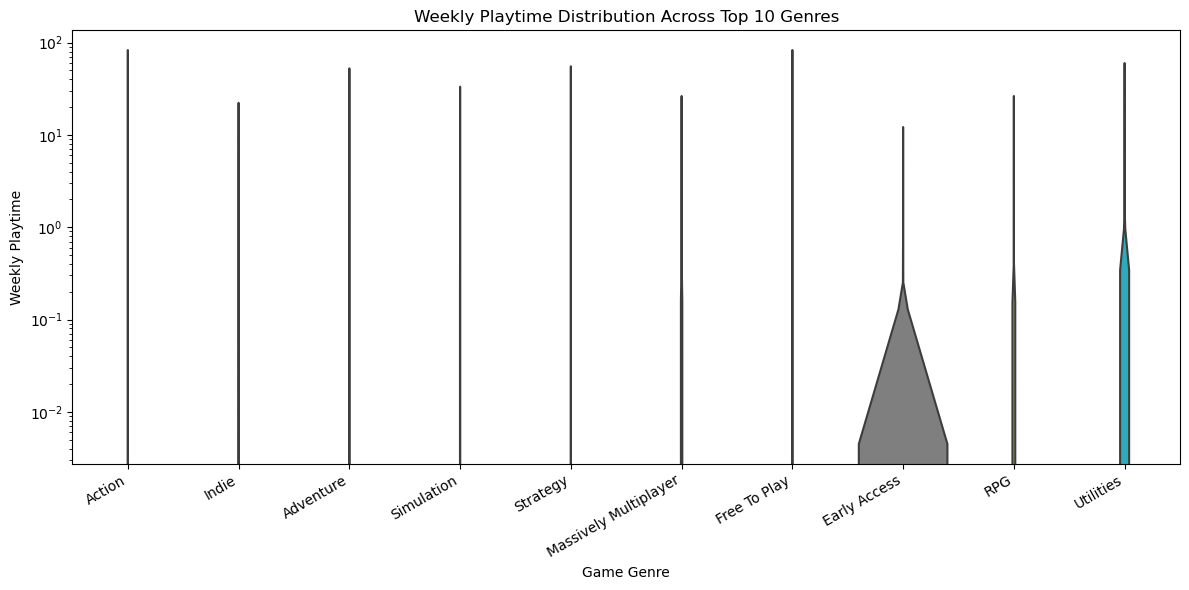

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Ensure 'playtime_2weeks' is numeric
merged_data["playtime_2weeks"] = pd.to_numeric(merged_data["playtime_2weeks"], errors="coerce").fillna(0)

# Convert to per-week playtime
merged_data["playtime_per_week"] = merged_data["playtime_2weeks"] / 2

# 1. Distribute playtime across individual genres
genre_playtime_weekly = defaultdict(float)

for _, row in merged_data.iterrows():
    if isinstance(row["genre"], str):  # Ensure genre is valid
        genres = row["genre"].split(", ")  # Split multi-genre entries
        genre_count = len(genres)
        playtime_share = row["playtime_per_week"] / genre_count  # Distribute playtime equally

        for genre in genres:
            genre_playtime_weekly[genre] += playtime_share

# Convert to DataFrame and keep top 10 most played genres
genre_playtime_weekly_df = pd.DataFrame(list(genre_playtime_weekly.items()), columns=["Genre", "Total Playtime (Per Week)"])
top_genres = genre_playtime_weekly_df.sort_values(by="Total Playtime (Per Week)", ascending=False).head(10)["Genre"].tolist()

# 2. Expand dataset: Assign each game its individual genres for filtering
expanded_rows = []
for _, row in merged_data.iterrows():
    if isinstance(row["genre"], str):
        genres = row["genre"].split(", ")
        genre_count = len(genres)
        playtime_share = row["playtime_per_week"] / genre_count
        
        for genre in genres:
            if genre in top_genres:  # Only keep top genres
                expanded_rows.append({"Genre": genre, "Playtime Per Week": playtime_share})

# Convert expanded data to DataFrame
expanded_df = pd.DataFrame(expanded_rows)

# 3. Compute summary statistics
summary_stats = expanded_df.groupby("Genre")["Playtime Per Week"].describe()[["mean", "50%", "25%", "75%"]]
summary_stats.rename(columns={"50%": "Median", "25%": "25th Percentile", "75%": "75th Percentile"}, inplace=True)


print("Weekly Playtime Summary per Genre",summary_stats)

# 4. Create violin plot for distribution shape
plt.figure(figsize=(12, 6))
sns.violinplot(x=expanded_df["Genre"], y=expanded_df["Playtime Per Week"], inner="quartile")
plt.xticks(rotation=30, ha="right")  # Rotate for readability
plt.xlabel("Game Genre")
plt.ylabel("Weekly Playtime")
plt.title("Weekly Playtime Distribution Across Top 10 Genres")
plt.yscale("log")  # Log scale helps see variations
plt.tight_layout()
plt.show()



## Q4. Do highly addictive games tend to have higher or lower ratings, and what are the most common sentiments expressed in player reviews? 

## Logistic Reg

Unique values in categorical columns (before encoding):
genre: ['Action, Indie, Simulation, Early Access' 'Action, Indie, Free To Play'
 'Action, Adventure, Indie' 'Action, Adventure, RPG' 'Action'
 'Action, Adventure, Indie, RPG' 'RPG' 'Indie, Simulation'
 'Casual, Indie, Racing, Simulation, Free To Play'
 'Indie, Simulation, Strategy' 'Casual, Indie, Simulation, Strategy'
 'Action, Adventure' 'Casual, Simulation' 'Simulation' 'Adventure, Indie'
 'Adventure, Casual, Indie, Simulation'
 'Casual, Free To Play, Indie, RPG, Simulation'
 'Action, Adventure, Casual, Indie, RPG'
 'Action, Casual, Indie, Massively Multiplayer, Free To Play'
 'Action, Adventure, Massively Multiplayer, Free To Play'
 'Action, Free To Play' 'Action, Adventure, Indie, Simulation'
 'Action, Free To Play, Early Access' 'Action, Adventure, Casual, Indie'
 'Strategy' 'Action, Adventure, Indie, Massively Multiplayer, RPG'
 'Action, Indie, RPG' 'Action, Free To Play, Massively Multiplayer'
 'Casual, Indie'
 'Action, Ad

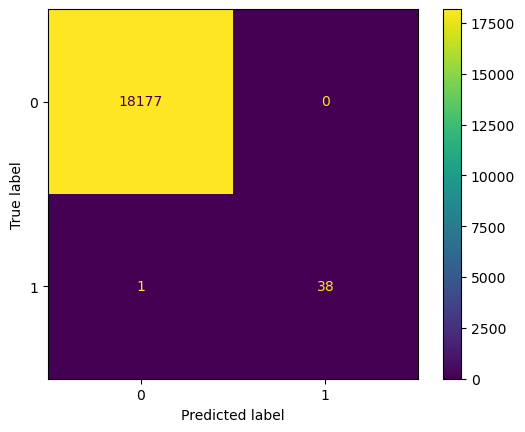

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


users_data["playtime_2weeks"] = pd.to_numeric(users_data["playtime_2weeks"], errors="coerce").fillna(0)
users_data["playtime_per_week"] = users_data["playtime_2weeks"] / 2
threshold_hours = 20  
users_data["addicted"] = (users_data["playtime_per_week"] > threshold_hours).astype(int)  # Binary target variable


merged_data = users_data.merge(games_data, on="game_id", how="inner")
numeric_features = ["playtime_per_week", "DLC_count", "story_depth", "average_review_score"]
categorical_features = ["genre", "multiplayer_support"]  # These need encoding


for col in categorical_features:
    merged_data[col] = merged_data[col].astype(str)


for col in numeric_features:
    merged_data[col] = pd.to_numeric(merged_data[col], errors="coerce").fillna(0)  # Convert to numeric

merged_data = merged_data[merged_data["playtime_forever"] > 1]

# Extract features and target
X = merged_data[numeric_features + categorical_features]
y = merged_data["addicted"]


#Column Transformer - Encode categorical data properly**
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),  # Scale numeric features
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)  # One-hot encode categorical
])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **Fix 4: Check X_train for non-numeric values before passing to the model**
print("Unique values in categorical columns (before encoding):")
for col in categorical_features:
    print(f"{col}: {X_train[col].unique()}")  # Debugging step

# Build Logistic Regression Pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=500))
])

# Train the Model
pipeline.fit(X_train, y_train)

# Prediction
y_pred_test = pipeline.predict(X_test)

# Evaluate Model Performance
logistic_regression_scores = {
    'Accuracy Score': accuracy_score(y_test, y_pred_test),
    'Precision Score': precision_score(y_test, y_pred_test),
    'Recall Score': recall_score(y_test, y_pred_test),
    'F1 Score': f1_score(y_test, y_pred_test)
}

# Store results
Model_Accuracies = {
    "Accuracy Score": [],
    "Precision Score": [],
    "Recall Score": [],
    "F1 Score": []
}

for metric, value in logistic_regression_scores.items():
    print(f'{metric} = {value:.4f}')
    Model_Accuracies[metric].append(value)

# Display Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
